## Clasificación de los dígitos de Mnist en forma de set de puntos

In [1]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/')
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import *
from src.fspool import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm

### Preparamos los datos de entreno y test

In [2]:
batch_size = 32

In [3]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

In [4]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [5]:
set_channels = 2
set_size = 342
hidden_dim = 32
latent_dim = 16
lr = 0.001
n_epochs = 10
net = FSEncoder(set_channels,latent_dim,hidden_dim)

In [6]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [7]:
net

FSEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (pool): FSPool()
)

In [ ]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input, target_set, target_mask = map(lambda x: x, sample)
            optimizer.zero_grad()
            output = net(target_set,target_mask)
            loss = F.cross_entropy(output, input)
            acc = (output.max(dim=1)[1] == input).float().mean()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

In [ ]:
net.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x.cuda(), sample)
        output = net(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

In [ ]:
#torch.save(net.state_dict(),'model.pth')

In [8]:
model = torch.load('./FSEncoder_model_mnist.pth' ,map_location=torch.device('cpu'))
miNet = FSEncoder(set_channels,latent_dim,hidden_dim)

In [9]:
miNet.load_state_dict(torch.load('./FSEncoder_model_mnist.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
miNet = miNet
miNet.eval()
losses = []
accs = []
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())
print('loss: {}, acc: {}'.format(round(sum(losses)/len(losses),2),round(sum(accs)/len(accs),2)))

Epoch 0:  48%|█████████████▉               | 150/312 [03:49<04:32,  1.68s/batch, acc=100, loss=0.0423]

In [ ]:
for name, param in miNet.named_parameters():
    print(name, param.size())

In [ ]:
model.classifier = nn.Sequential(*[miNet.conv[i] for i in range(3)])
print(model.classifier)

## Puntos Críticos

In [ ]:
get_weight(miNet)

In [ ]:
dataset_mnist_set = MNISTSet(full=True)
class_names =   [ 0 , 1 , 2,  3 , 4 , 5 , 6 , 7 ,  8 ,  9]
sampleSet = []
sampleMask = []
for i in range(len(class_names)):
    for j in range(len(dataset_mnist_set)):
        if i == dataset_mnist_set[j][0]:
            sampleSet.append(dataset_mnist_set[j][1])
            sampleMask.append(dataset_mnist_set[j][2])
            break
fig = plt.figure(figsize=(20, 20))

for i,set in enumerate(sampleSet):
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'k')
    plt.axis([0, 1, 1, 0])
    plt.title('Label: {}'.format(i))

In [ ]:
with torch.no_grad():
    for i in range(len(sampleSet)):
        pred = miNet(sampleSet[i].unsqueeze(0),sampleMask[i].unsqueeze(0))
        print("We obtained {}, and the expected is: {} with probaility".format(np.argmax(pred).item(),class_names[i]))

In [ ]:
model1 = MaxEncoder(set_channels,latent_dim,hidden_dim)
model1 = torch.nn.Sequential(*(list(miNet.children())[:-3]))
print(model1)

In [ ]:
with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.subplot(1,2,1) 
    pred = model1(sampleSet[8].unsqueeze(0))
    feature_map = pred
    data = pred.squeeze(0).detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la primera capa")
    plt.subplot(1,2,2) 
    pred = pred.max(2)[0]
    max_map = pred
    print(max_map.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la operación invariante al orden")
    plt.show()

In [ ]:
def critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    #Salida de la capa de convoluciones
    pred = model(sample.unsqueeze(0))
    features_map = pred.squeeze(0)
    #print(features_map.shape)
    #Aplicamos la operación invariante max
    xmax = features_map.max(axis=1)[0]
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    
    for k in range(len(newxmaxargs)):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])
    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    s = np.stack((y,x))
    return s 

In [ ]:
crit = dataset_mnist_set[800][1]
s = critical_points_MaxEncoder(model1,crit)
s.shape

## Visualización de los puntos críticos

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i,set in enumerate(sampleSet):
    crit = critical_points_MaxEncoder(model1,set)
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'c',s=40)
    x = crit[1, :]
    y = crit[0, :]
    plt.scatter(x, y,marker='o',color = 'r',s=70)
    plt.axis([0, 1, 1, 0])
    plt.title('Puntos Criticos')
plt.show()

In [ ]:
crit = dataset_mnist_set[34][1]
s = critical_points_MaxEncoder(model1,crit)
st = torch.Tensor(s).unsqueeze(0)
print(st.shape)
muestraSintetica = torch.zeros(1,2,0)
muestraSintetica = torch.cat((st,muestraSintetica,),2)
mask_sintetica = torch.ones(1,st.size(2))
print(muestraSintetica.shape)
print(mask_sintetica.shape)

In [ ]:
sam = muestraSintetica.squeeze(0)
#print(sam)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2,1)
x1 = s[1, :]
y1 = s[0, :]
plt.scatter(x1, y1,c ='r',s=40)
#plt.scatter(x1, y1,marker='x',color ='r')
plt.axis([0, 1, 1, 0])
ax = fig.add_subplot(1, 2,2)
x = crit[1, :]
y = crit[0, :]
plt.scatter(x, y,marker='o',color = 'k',s=70)
plt.axis([0, 1, 1, 0])
plt.title('Puntos Criticos')
plt.scatter(x1, y1,marker='o',color ='r')
plt.show()

In [ ]:
same = 0
not_same = 0
for i, sample in enumerate(dataset_mnist_set):
    s = critical_points_MaxEncoder(model1,sample[1])
    st = torch.Tensor(s).unsqueeze(0)
    pred = miNet(muestraSintetica,mask_sintetica)
    muestraSintetica = torch.zeros(1,2,0)
    muestraSintetica = torch.cat((st,muestraSintetica,),2)
    mask_sintetica = torch.ones(1,st.size(2))
    predMax = miNet(muestraSintetica,mask_sintetica)
    pred = miNet(sample[1].unsqueeze(0),sample[2].unsqueeze(0))
    if predMax.argmax() == pred.argmax()  :
        same+=1
    else:
        not_same+=1
print("Aciertos: ",same)
print("Falladis: ",not_same)

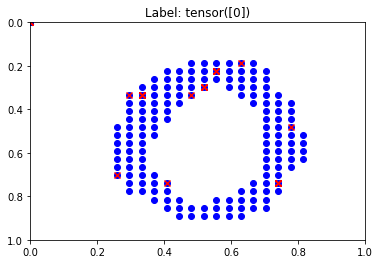

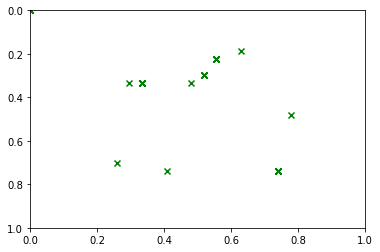

In [44]:
sam = sample.squeeze(0).numpy()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,color ='b')
x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='g')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

In [45]:
maxes = model2.pool.truco.argmin(2)[0].squeeze(0).numpy()
mines = model2.pool.truco.argmax(2)[0].squeeze(0).numpy()

In [46]:
points = sample.squeeze(0).numpy()
critical_points_ahmed_x = []
critical_points_ahmed_y = []
for k in range(len(maxes)):
    critical_points_ahmed_y.append(points[0,maxes[k]])
    critical_points_ahmed_x.append(points[1,maxes[k]])
for k in range(len(mines)):
    critical_points_ahmed_y.append(points[0,mines[k]])
    critical_points_ahmed_x.append(points[1,mines[k]])
#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(critical_points_ahmed_x))

64


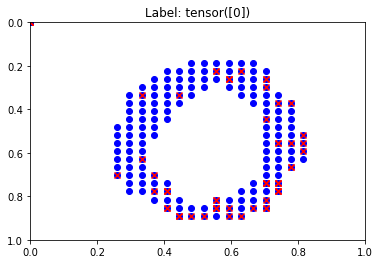

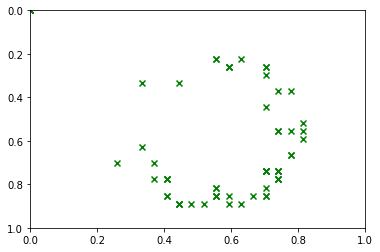

In [47]:
sam = sample.squeeze(0).numpy()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,color ='b')
x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='g')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

La problematica aqui es que con la operación del fspool, lo que se hace es coger y aplicarle al tensor de entrada de [1,32,342] unos pesos (de los cuales supuestamente salen de hacer una interpolación) y una vez que se realiza dicho producto, se suma la dimensión 2.
A la hora de hacer el unpooling, no se hace del todo debido a que creo que el código esta mal o algo, ya que lo que hace es coger el tensor fspool, y aplicarle nuevamente el vector de pesos(?), cosa que creo que esta mal y que lo mas conveniente sería aplicarle la inversa de dichos pesos 

In [ ]:
miNet.pool.ahmed

In [ ]:
with torch.no_grad():
    pool = FSPool(2, 1,True)
    x = torch.arange(0, 2*3*4).view(3, 2, 4).float()
    print('x', x)
    y, perm = pool(x)
    print('perm')
    print(perm)
    print('result')
    print(y.sum())
    z,m = pool.forward_transpose(y,perm)
    print(z)
    tensorFspool = x[0]
    print(tensorFspool)
    print(pool.forward(tensorFspool))